# Buoy localisation
We will use a Gaussian mixture model to localise the buoys.
A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. One can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians.

The non-probabilistic nature of k-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.
Unfortunately, the k-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
An important observation for k-means is that these cluster models must be circular: k-means has no built-in way of accounting for oblong or elliptical clusters.

Variational Bayesian estimation of a Gaussian mixture.

This class allows to infer an approximate posterior distribution over the parameters of a Gaussian mixture distribution. The effective number of components can be inferred from the data

In [35]:
import numpy as np, matplotlib.pyplot as plt
from sklearn.mixture import BayesianGaussianMixture
from sklearn.cluster import KMeans
import sys; sys.path.append('../src/')
import bt_actions
import importlib
%matplotlib inline

In [36]:
# ground truth walls
lines = np.load('walls.npy')
points = np.vstack(lines)

In [37]:
# generate data
importlib.reload(bt_actions)
samples = bt_actions.A_ReadBuoys.generate_data(points=points, n_samples=500, sigma=1)
samples

array([[ 5.49442695e+00,  1.32481593e+01, -7.58827613e-01],
       [-1.41392482e+01,  5.31581802e+00, -1.07498234e+00],
       [-1.56653781e+00,  1.10342562e+01, -7.88899910e-01],
       ...,
       [ 8.03390654e+00,  6.64083981e+00,  1.58718169e-01],
       [ 5.36707030e+00, -1.61039751e+00, -1.33666775e-02],
       [-7.11908577e+00,  8.03186875e+00,  8.84880045e-02]])

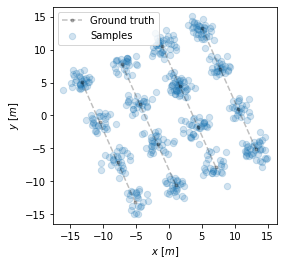

In [38]:
# plotting
importlib.reload(bt_actions)
fig, ax = bt_actions.A_ReadBuoys.plot(lines=lines, samples=samples)
plt.show()

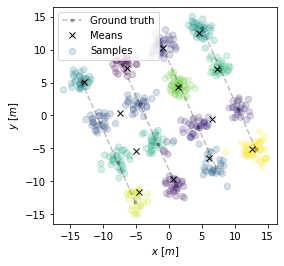

In [39]:
# clustering
importlib.reload(bt_actions)
mu, sigma, gsigma, labels = bt_actions.A_ReadBuoys.approximate(samples=samples, n_components=16)
fig, ax = bt_actions.A_ReadBuoys.plot(means=mu, samples=samples, lines=lines, c=labels)
plt.show()

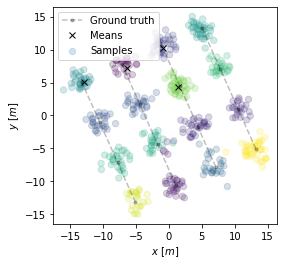

In [40]:
# filtering means based on generalized varaiance
importlib.reload(bt_actions)
sigma_tol = 15.0
fig, ax = bt_actions.A_ReadBuoys.plot(means=mu[gsigma<sigma_tol], samples=samples, lines=lines, c=labels)
plt.show()

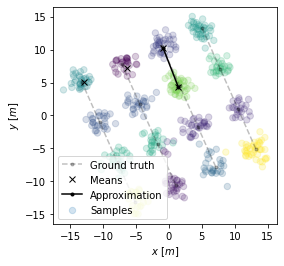

In [41]:
# inferring lines from the data given a priori theta=116 [deg] and n_lines=4
importlib.reload(bt_actions)
sample_lines = bt_actions.A_ReadBuoys.infer_lines(points=mu[gsigma<sigma_tol], theta=116, n_lines=4, atol=1e-2, dtol=1.0)
fig, ax = bt_actions.A_ReadBuoys.plot(means=mu[gsigma<sigma_tol], samples=samples, lines=lines, sample_lines=sample_lines, c=labels)
plt.show()


Number of samples: 100
Number of buoys approximated: 6
Number of certain buoys: 0
Number of lines infered: 0


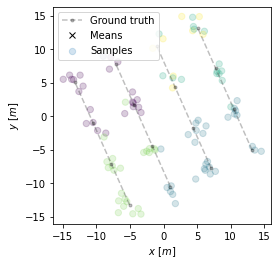


Number of samples: 200
Number of buoys approximated: 5
Number of certain buoys: 0
Number of lines infered: 0


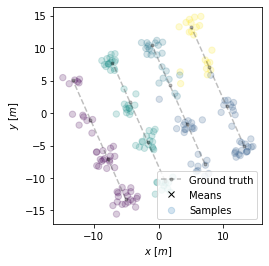


Number of samples: 300
Number of buoys approximated: 10
Number of certain buoys: 0
Number of lines infered: 0


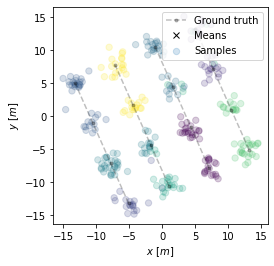


Number of samples: 400
Number of buoys approximated: 7
Number of certain buoys: 0
Number of lines infered: 0


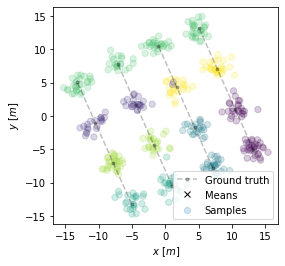

/usr/local/lib/python3.8/dist-packages/sklearn/mixture/_base.py:265: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn('Initialization %d did not converge. '

Number of samples: 500
Number of buoys approximated: 12
Number of certain buoys: 7
Number of lines infered: 2


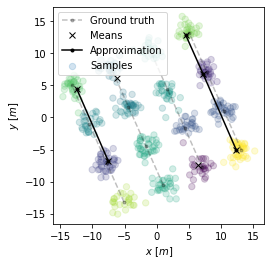


Number of samples: 600
Number of buoys approximated: 14
Number of certain buoys: 13
Number of lines infered: 4


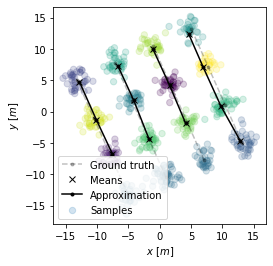


Number of samples: 700
Number of buoys approximated: 12
Number of certain buoys: 10
Number of lines infered: 3


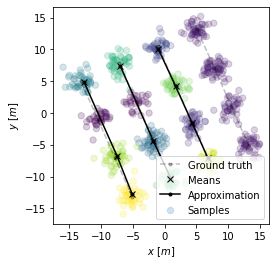


Number of samples: 800
Number of buoys approximated: 16
Number of certain buoys: 16
Number of lines infered: 4


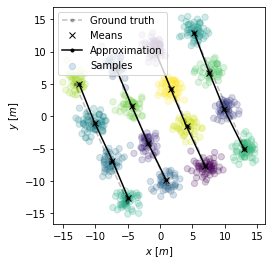


Number of samples: 900
Number of buoys approximated: 16
Number of certain buoys: 16
Number of lines infered: 4


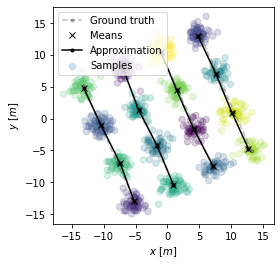


Number of samples: 1000
Number of buoys approximated: 16
Number of certain buoys: 16
Number of lines infered: 4


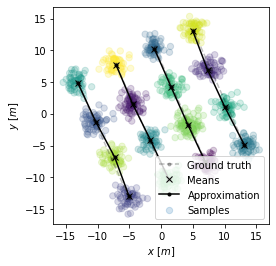

In [42]:
# let's put it all together...
importlib.reload(bt_actions)

# variance of sampling
sigma = 1.0
# number of buoys (a priori)
n_components = 16
# generalised variance tolerance
gsigma_tol = 10.0
# number of lines (a priori)
n_lines = 4
# line-angle tolerance
atol=1e-2
# line-inclusion distance tolerance
dtol=1e-2
# use trace
use_trace = True

# loop through different number of samples,
# incrementally updating the Gaussian mixture model
for n_samples in np.arange(100, 1100, step=100):

    # gather data
    samples = bt_actions.A_ReadBuoys.generate_data(
        points=points, 
        n_samples=n_samples, 
        sigma=sigma
    )

    # localise buoys
    mu, covar, gsigma, labels = bt_actions.A_ReadBuoys.approximate(
        samples=samples, 
        n_components=n_components,
        use_trace=use_trace
    )

    # infer walls
    sample_lines = bt_actions.A_ReadBuoys.infer_lines(
        points=mu[gsigma<sigma_tol], 
        theta=116, 
        n_lines=4, 
        atol=1e-2, 
        dtol=1.0
    )
    
    # information
    print('')
    print('Number of samples: {}'.format(n_samples))
    print('Number of buoys approximated: {}'.format(mu.shape[0]))
    print('Number of certain buoys: {}'.format(mu[gsigma<sigma_tol].shape[0]))
    print('Number of lines infered: {}'.format(len(sample_lines)))

    # plot it
    fig, ax = bt_actions.A_ReadBuoys.plot(
        lines=lines,
        samples=samples,
        means=mu[gsigma<sigma_tol], 
        sample_lines=sample_lines, 
        c=labels
    )
    # fig.savefig('img/buoys_{}.png'.format(n_samples), dpi=1000, bbox_inches='tight')
    plt.show()

In [43]:
line = sample_lines[0]
line

array([[  1.18529982, -10.23524376,  -0.08365359],
       [ -1.68050589,  -4.10945327,  -0.1069847 ],
       [ -4.4812184 ,   1.54251595,   0.16531971],
       [ -7.06278698,   7.64878734,  -0.19804447]])